In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../output/fico_style_features.csv")
print(f"✅ Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")

✅ Dataset loaded: 307511 samples, 15 features


In [2]:
selected_features = [
    "on_time_ratio",          # Tỷ lệ trả đúng hạn
    "total_utilization",      # Tỷ lệ sử dụng tín dụng
    "dpd_mean",               # Số ngày trễ hạn trung bình
    "aaoa_m",                 # Tuổi trung bình tài khoản
    "AMT_CREDIT_SUM_DEBT",    # Tổng dư nợ
    "thin_file_flag"          # Có lịch sử tín dụng hay không
]

X = df[selected_features]
y = df["TARGET"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
model_small = LogisticRegression(
    class_weight="balanced", 
    max_iter=1000, 
    solver="lbfgs", 
    C=0.8
)
model_small.fit(X_train_scaled, y_train)
print("Mini Logistic Regression model trained successfully.")

Mini Logistic Regression model trained successfully.


In [5]:
y_pred = model_small.predict(X_test_scaled)
y_proba = model_small.predict_proba(X_test_scaled)[:, 1]

print("\n📈 Evaluation Metrics (Mini Model):")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


📈 Evaluation Metrics (Mini Model):
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     84806
           1       0.11      0.59      0.19      7448

    accuracy                           0.58     92254
   macro avg       0.53      0.59      0.45     92254
weighted avg       0.87      0.58      0.67     92254

ROC-AUC: 0.6153


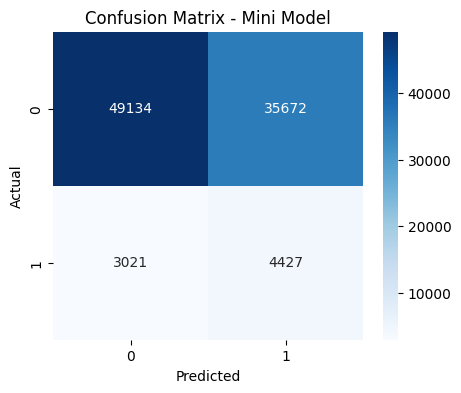

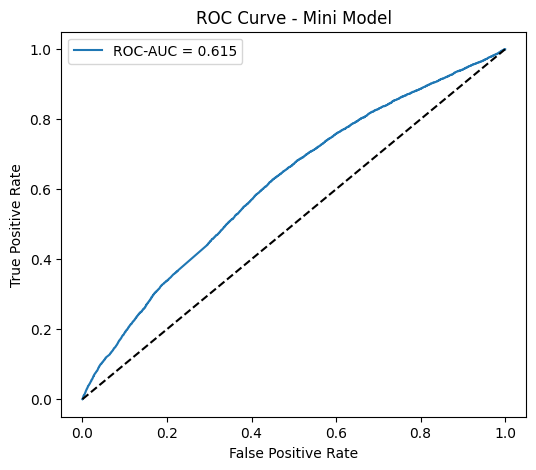

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Mini Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Mini Model")
plt.legend()
plt.show()

In [8]:
import joblib
import os
os.makedirs("../output/models", exist_ok=True)

joblib.dump(model_small, "../output/models/logistic_model_mini.pkl")
joblib.dump(scaler, "../output/models/scaler_mini.pkl")
print("💾 Mini model and scaler saved successfully.")

💾 Mini model and scaler saved successfully.


In [9]:
# Load kết quả cũ 
roc_full = 0.64
roc_mini = roc_auc_score(y_test, y_proba)

improvement = roc_full - roc_mini
print(f"Baseline ROC-AUC (Full Model): {roc_full}")
print(f"Mini Model ROC-AUC: {roc_mini:.4f}")
print(f"Difference: {-improvement:.4f}")

if improvement < 0.03:
    print("🎯 Excellent! Mini model gần bằng baseline — có thể triển khai CLI gọn hơn.")
else:
    print("⚠️ Cần cải thiện thêm feature selection hoặc tuning.")


Baseline ROC-AUC (Full Model): 0.64
Mini Model ROC-AUC: 0.6153
Difference: -0.0247
🎯 Excellent! Mini model gần bằng baseline — có thể triển khai CLI gọn hơn.


In [12]:
# ======================================================
# 🧮 CLI Demo: Predict Credit Risk using Mini Logistic Model
# ======================================================

import numpy as np
import pandas as pd

print("💳 Credit Scoring Demo — Mini Logistic Regression Model")
print("-------------------------------------------------------")
print("Hãy nhập các thông tin dưới đây để mô hình dự đoán rủi ro tín dụng.")
print("(Bấm Enter để sử dụng giá trị mặc định trong ngoặc)\n")

def get_input(prompt, default):
    """Nhận input từ người dùng, cho phép dùng giá trị mặc định"""
    val = input(f"{prompt} [{default}]: ").strip()
    return float(val) if val != "" else float(default)

# --- Nhập dữ liệu khách hàng ---
on_time_ratio = get_input("Tỷ lệ trả đúng hạn (0–1)", 0.8)
total_utilization = get_input("Tỷ lệ sử dụng tín dụng (0–1)", 0.3)
dpd_mean = get_input("Số ngày trễ hạn trung bình", 2.0)
aaoa_m = get_input("Tuổi trung bình tài khoản tín dụng (tháng)", 30)
AMT_CREDIT_SUM_DEBT = get_input("Tổng dư nợ hiện tại (VNĐ)", 40000)
thin_file_flag = get_input("Khách hàng chưa từng vay trước đây? (1=Có, 0=Không)", 0)

# --- Tạo DataFrame đầu vào ---
sample = pd.DataFrame([{
    "on_time_ratio": on_time_ratio,
    "total_utilization": total_utilization,
    "dpd_mean": dpd_mean,
    "aaoa_m": aaoa_m,
    "AMT_CREDIT_SUM_DEBT": AMT_CREDIT_SUM_DEBT,
    "thin_file_flag": thin_file_flag
}])

# --- Chuẩn hóa dữ liệu ---
sample_scaled = scaler.transform(sample)

# --- Dự đoán ---
prob_default = model_small.predict_proba(sample_scaled)[0, 1]
pred = int(prob_default > 0.5)

# --- Hiển thị kết quả ---
print("\n-------------------------------------------------------")
print(f"🔹 Xác suất vỡ nợ: {prob_default:.2%}")
if pred == 1:
    print("❌ Kết luận: Khách hàng có rủi ro cao (Có thể vỡ nợ).")
else:
    print("✅ Kết luận: Khách hàng có rủi ro thấp (Khách hàng tốt).")
print("-------------------------------------------------------")

💳 Credit Scoring Demo — Mini Logistic Regression Model
-------------------------------------------------------
Hãy nhập các thông tin dưới đây để mô hình dự đoán rủi ro tín dụng.
(Bấm Enter để sử dụng giá trị mặc định trong ngoặc)


-------------------------------------------------------
🔹 Xác suất vỡ nợ: 46.54%
✅ Kết luận: Khách hàng có rủi ro thấp (Khách hàng tốt).
-------------------------------------------------------
